In order to find potential binding motifs for transcription factors, I will use a type of algorithm that is called "Gibbs sampling". What this algorithm does is randomly take a kmer of a specific length of each DNA-string. It uses this to score the current list of motifs with cross-entropy, hereby the similarity between motifs is quantified taking into account the nucleotide frequencies of the input strings. The initial selection of motifs will be very bad because they are randomly chosen, but each iteration a (weighted) random motif is removed from the list and a new relative entropy is calculated. If this increases the relative entropy, this new set of motifs will be the new best list of motifs. The algorithm continues doing this untill the relative entropy score does not increase for 100 iterations, meaning that it will have found the best list of motifs.

Although this algorithm will perform well in many cases, it may converge to a local optimum where it will get stuck. Therefore, the Gibbs algorithm has to be run many times with the hope that one of these will return the best-scoring motif.

In [51]:
# code for the Gibbs sampling algorithm

import numpy as np
import pandas as pd
import random
import itertools
from scipy import stats
from math import log2
import matplotlib.pyplot as plt

# return the Hamming distance between 2 DNA-strings (amount of mismatches)
def get_hamming_distance(p, q):
    count = 0
    for pos in zip(list(p), list(q)):
        if pos[0] != pos[1]:
            count += 1
    return count

# get all k-mers of a sequence
def get_kmers(input, k):
    return [input[i:i+k] for i in range(len(input)-k+1)]

# get the most probable k-mer using a profile of bases
def profile_most_probable(genome, k, profile):
    kmers = get_kmers(genome, k)
    output = {}

    for kmer in kmers:
        profiles = []
        for index, base in enumerate(kmer):
            if base == "A":
                id = 0
            if base == "C":
                id = 1
            if base == "G":
                id = 2
            if base == "T":
                id = 3
            profiles.append(profile[index][id])
        output.update({kmer: np.product(profiles)})

    return max(output, key = output.get)

# get the profile matrix for a list of sequences
def get_profile_matrix(data, laplace):
    # convert to list if only single string is given
    data = [data] if isinstance(data, str) else data    
    
    # create an empty list for each of the 4 nucleotides with length of each kmer
    profile = [[] for x in range(len(data[0]))]
    # get a dictionary with the location for each nucleotide
    n = ["A", "C", "G", "T"]
    output = []
        
    for i in data:
        for index, base in enumerate(i):
            profile[index].append(base)
   
    for index in profile:
        temp = []
        output.append(temp)
        for i in n:
            temp.append(index.count(i))

    if laplace == 1:
        # add 1 to utilize Laplace's rule
        return [[(j+1)/(len(data)) for j in i] for i in output]
    else:
        return [[(j)/(len(data)) for j in i] for i in output]

# get the relative frequency of the DNA strings to calculate the cross-entropy
def get_nucleotide_frequencies(genome):
    A = 0
    C = 0
    G = 0
    T = 0

    for region in genome:
        A += region.count("A")
        C += region.count("C")
        G += region.count("G")
        T += region.count("T")

    sum = A+C+G+T

    return [A/sum, C/sum, G/sum, T/sum]

# score the motif list with relative entropy
def score_motifs(data, n_freq):
    # create an empty list for each of the 4 nucleotides with length of each kmer
    profile = [[] for x in range(len(data[0]))]
    # get a dictionary with the location for each nucleotide
    n = ["A", "C", "G", "T"]
    output = []
    
    # start is very similar to get_profile function   
    for i in data:
        for index, base in enumerate(i):
            profile[index].append(base)

    # get the profile relative profile matrix 
    for index in profile:
        temp = []
        output.append(temp)
        for i in n:
            temp.append(index.count(i) / len(data))

    # calculate the entropy and the cross-entropy for each element of the profile matrix
    entropy = []
    cross_entropy = []

    for profile in output:
        temp = []
        temp2 = []
        entropy.append(temp)
        cross_entropy.append(temp2)
        for index, ele in enumerate(profile):
            temp2.append(ele*log2(n_freq[index]))
            if ele == 0:
                temp.append(0)
            else:
                temp.append(ele*log2(ele))

    # the final relative entropy score is the cross_entropy minus the entropy
    entropy_score = [sum(ele) for ele in entropy]
    cross_entropy_score = [sum(ele) for ele in cross_entropy]
    
    return -sum(cross_entropy_score) + sum(entropy_score)

# get random kmers from a DNA string
def random_kmer(genome, k):
    random_motifs = []
    dna_string_len = len(genome[0])
    
    for seq in genome:
        random_index = random.randrange(dna_string_len-k+1)
        random_motifs.append(seq[random_index:random_index+k])
    
    return random_motifs

# use a biased random sampler to select a random kmer
def random_gibbs(t):
    # get t random numbers
    rand = [random.random() for i in range(t)]
    
    # divide by sum to get random numbers equalling to 1
    sum_rand = [i/sum(rand) for i in rand]
        
    # create a specific distribution
    gibbs = stats.rv_discrete(name = "gibbs", values = (np.arange(t), sum_rand))
    
    # return a random biased kmer
    return gibbs.rvs()

# Gibbs sampler randomly removes a motif from the motif list and evaluates if the 
# score increases
def gibbs_sampler(genome, k, t, n):
    # get random kmers
    best_motifs = random_kmer(genome, k)
    motifs = random_kmer(genome, k)
    # get the relative nucleotide frequencies for the cross-entropy calculation
    n_freq = get_nucleotide_frequencies(genome)
    
    for _ in range(n):
        # get biased kmer index
        i = random_gibbs(t)
        # remove this kmer
        motifs.pop(i)
        profile = get_profile_matrix(motifs, True)
        # find the most probable replacement motif in genome[i] and add back
        motif_i = profile_most_probable(genome[i], k, profile)
        motifs.insert(i, motif_i)
        
        # we want to maximize the relative-entropy so if the score is higher we will keep that list of motifs
        if score_motifs(motifs, n_freq) > score_motifs(best_motifs, n_freq):
            best_motifs = motifs
        
    return best_motifs

# The final Gibbs motif search algorithm that gives the motif with the score that did not change
# after 100 consecutive calls for gibbs_sampler
def gibbs_motif_search(genome, k, t, n):
    highest_best_score = 0
    highest_motif = []
    # get the relative nucleotide frequencies for the cross-entropy calculation
    n_freq = get_nucleotide_frequencies(genome)
    
    i = 0
    while True:
        best_motif = gibbs_sampler(genome, k, t, n)
        best_score = score_motifs(best_motif, n_freq)
        if best_score > highest_best_score:
            highest_best_score = best_score
            highest_motif = best_motif
            i = 0
        else:
            i += 1
        if i == 100:
            break
    
    return highest_motif

In this project I will use the Gibbs sampling algorithm to determine the possible binding motif of the transciptional regulator of Mycobacterium tuberculosis under anoxic conditions. This bacterium still causes millions of deaths each year due to antibiotic-resistant strains. One of the reasons that M. tuberculosis is hard to treat is that it can survive for decades in humans without causing disease. It is unclear how exactly this bacterium can remain dormant, but it has been found that it can sporulate under hypoxic conditions with (very) low oxygen levels.

Sporulation genes are under strict control by transcription factors that can sense such low-oxygen environments before allowing transcription and subsequent translation of sporulation genes. This regulator protein was found in 2003 and was termed 'dormancy survival regulator' (DosR). Park et al. (2003, https://doi.org/10.1046/j.1365-2958.2003.03474.x) did transcriptomics under low oxygen concentrations and found 25 genes to be significantly upregulated. I will use a set of 10 of these genes with the 250 nucleotides upstream in order to try to find the binding motif for DosR. The length of the motif is 20 basepairs.

In [81]:
# load in the data
genome = open("DosR.txt", "r").readlines()

Run the Gibbs motif search algorithm:

In [82]:
result = gibbs_motif_search(genome, 20, len(genome), 2000)
print(result)

['GCCGGGACTTCAGGCCCTAT', 'CACGGGTCAAACGACCCTAG', 'GGCGGGACGTAAGTCCCTAA', 'CGCTGGATTACCGACCGCAG', 'TTCGTGACCGACGTCCCCAG', 'TTGAGGACCTTCGGCCCCAC', 'TCGGGGACTTCTGTCCCTAG', 'CATGGGACTTTCGGCCCTGT', 'GTGGGGACCAACGCCCCTGG', 'CTGGGGACCGAAGTCCCCGG']


The Gibbs motif search algorithm took 5 minutes to find the binding motif. Now I can plot the consensus motif with the nucleotide probabilities:

Text(0, 0.5, 'Percentage identity')

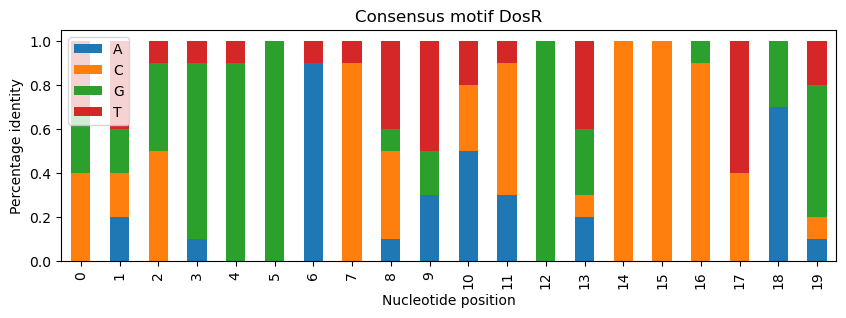

In [87]:
df = pd.DataFrame(get_profile_matrix(result, False), columns = ['A', 'C', 'G', 'T'])
df.plot(kind='bar', stacked=True, figsize=(10, 3))
plt.title("Consensus motif DosR")
plt.xlabel("Nucleotide position")
plt.ylabel("Percentage identity")

| Position| Motif found by me | Motif found by Park et al. |
| --- | --- | --- |
| 0 | C/G/T | T |
| 1 | T | T |
| 2 | C/G | C/G |
| 3 | G | G |
| 4 | G | G |
| 5 | G | G |
| 6 | A | A |
| 7 | C | C |
| 8 | C/T | T |
| 9 | A/T | A/T |
| 10 | A | A/T |
| 11 | C | A |
| 12 | G | G |
| 13 | T | T |
| 14 | C | C |
| 15 | C | C |
| 16 | C | C |
| 17 | C/T | C/G |
| 18 | A | A |
| 19 | G | A |

The motif is very similar to the real binding motif as found by Park et al.!